In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/MyDrive/Github/ARDL

Mounted at /content/drive
/content/drive/MyDrive/Github/ARDL


In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision
import os
import sys
from torch.autograd import Variable


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [95]:
class ARDL_Net(nn.Module):
    def __init__(self, list_CNN, list_DNN, list_LSTM, output_size=7):
        super(ARDL_Net, self).__init__()
        self.list_CNN = nn.ModuleList(list_CNN)
        self.list_DNN = nn.ModuleList(list_DNN)
        self.list_LSTM = nn.ModuleList(list_LSTM)
        self.softmax = nn.Softmax()
        # todo
        self.fc1 = nn.Linear(output_size, 1)
        self.fc3 = nn.Linear(len(list_CNN) + len(list_DNN) + len(list_LSTM), len(list_CNN) + len(list_DNN) + len(list_LSTM))

    def forward(self, x):
        out_list_a = []
        out_list_x = []
        
        for model in self.list_CNN:
          a1, x1 = model(x)
          out_list_a.append(self.fc1(a1))
          out_list_x.append(x1)

        for model in self.list_DNN:
          a1, x1 = model(x) # BS x output_size
          out_list_a.append(self.fc1(a1))
          out_list_x.append(x1)
        
        for model in self.list_LSTM:
          a1, x1 = model(x)
          out_list_a.append(self.fc1(a1)) #totoal_models [ BS x 1 ]
          out_list_x.append(x1)
        
        a = torch.cat(tuple(out_list_a), 1) # BS x num_models
        a = self.softmax(a)
        a = self.fc3(a)
        total = None
        for i, x_i in enumerate(out_list_x):
          if total is None:
            total =  a[:,i].view(-1,1)*x_i

          else:
            total += a[:,i].view(-1,1)*x_i
        return F.log_softmax(total)

In [75]:
# CNN
import pickle

cnn_models = []
path = "models/cnn"
files = os.listdir(path)

for file in files:
    if "model" in file and "10" in file:
        try:
            cnn_models.append(pickle.load(open(f"{path}/{str(file)}/model_architecture.pickle", 'rb')))
        except Exception as e:
            print("Cannot load model... File not present")


    


In [76]:
# DNN
import pickle

dnn_models = []
path = "models/dnn"
files = os.listdir(path)

for file in files:
    if "model" in file and "10" in file:
        try:
            dnn_models.append(pickle.load(open(f"{path}/{str(file)}/model_architecture.pickle", 'rb')))
        except Exception as e:
            print("Cannot load model... File not present")

In [77]:
# LSTM
import pickle

lstm_models = []
path = "models/lstm"
files = os.listdir(path)

for file in files:
    if "model" in file:
        try:
            lstm_models.append(pickle.load(open(f"{path}/{str(file)}/model_architecture.pickle", 'rb')))
        except Exception as e:
            print(e)
            print("Cannot load model... File not present")

In [78]:
lstm_models.pop()

LSTM(
  (embedding): Embedding(151353, 50)
  (lstm): LSTM(50, 37, num_layers=3, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=18500, out_features=7, bias=True)
  (att): Linear(in_features=18500, out_features=7, bias=True)
)

In [79]:
a = [cnn_models, lstm_models, dnn_models]
for i, models in enumerate(a):
  for j in range(len(models)):
    a[i][j] = a[i][j].to(device)

In [80]:
next(lstm_models[0].parameters()).device

device(type='cuda', index=0)

In [96]:
mynet = ARDL_Net(cnn_models, dnn_models, lstm_models)

In [82]:
%load_ext autoreload
%autoreload 2

from dataset import *
from torch.utils.data import TensorDataset, DataLoader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')


In [84]:
emb_mat, data = create_inp_data_and_weights(newsgroups_train, newsgroups_test, glove_dim=50)

Vocabulary size [Bag-of-words]:  151353
Vocabulary size [GloVe]:  400000


In [117]:
learning_rate = 0.000000001
num_epochs = 30
batch_size = 512
display_step = 4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mynet.parameters(), lr=learning_rate)

In [97]:
mynet = mynet.to(device)

In [98]:
for name, param in mynet.named_parameters():
  if "list_DNN" in name or "list_LSTM" in name or "list_CNN" in name: 
    
    param.requires_grad = False
  if "att" in name:
    param.requires_grad = True


In [118]:
# training_loss = []
# validation_loss = []
total_batch = int(len(newsgroups_train.data)/batch_size)
    
total_batch_val = int(len(newsgroups_test.data)/batch_size)
    


for epoch in range(30):
    tr_loss = []
    mynet.train()

    # Loop over all batches
    for i in range(total_batch):
        batch_x,batch_y = get_batch(data['train'],i,batch_size)

        articles = Variable(torch.LongTensor(batch_x)).to(device)
        labels = Variable(torch.LongTensor(batch_y)).to(device)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = mynet(articles)

        #print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        tr_loss.append(loss.data)
    
    print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
            %(epoch+1, num_epochs, i+1, len(newsgroups_train.data)//batch_size, sum(tr_loss)/total_batch))    

    training_loss.append(sum(tr_loss)/total_batch)

    mynet.eval()
    # Loop over all batches
    batch_val_loss = []
    for i in range(total_batch_val):
        
        batch_x,batch_y = get_batch(data['test'],i,batch_size)

        articles = Variable(torch.LongTensor(batch_x)).to(device)
        labels = Variable(torch.LongTensor(batch_y)).to(device)

        y_test_pred = mynet(articles)
        
        test_loss = criterion(y_test_pred, labels)
        batch_val_loss.append(test_loss.data)

    validation_loss.append(sum(batch_val_loss)/total_batch_val)
    print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
            %(epoch+1, num_epochs, i+1, len(newsgroups_test.data)//total_batch_val, sum(batch_val_loss)/total_batch_val))    

/content/drive/MyDrive/Github/ARDL/cnn.py:60: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return a, F.log_softmax(y)
/content/drive/MyDrive/Github/ARDL/dnn.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return a, F.log_softmax(y)
/content/drive/MyDrive/Github/ARDL/lstm.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return a, F.log_softmax(y)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/30], Step [22/22], Loss: 0.5233
Epoch [1/30], Step [14/538], Loss: 0.7326
Epoch [2/30], Step [22/22], Loss: 0.5227
Epoch [2/30], Step [14/538], Loss: 0.7304
Epoch [3/30], Step [22/22], Loss: 0.5232
Epoch [3/30], Step [14/538], Loss: 0.7330
Epoch [4/30], Step [22/22], Loss: 0.5244
Epoch [4/30], Step [14/538], Loss: 0.7303
Epoch [5/30], Step [22/22], Loss: 0.5255
Epoch [5/30], Step [14/538], Loss: 0.7297
Epoch [6/30], Step [22/22], Loss: 0.5215
Epoch [6/30], Step [14/538], Loss: 0.7300
Epoch [7/30], Step [22/22], Loss: 0.5238
Epoch [7/30], Step [14/538], Loss: 0.7307
Epoch [8/30], Step [22/22], Loss: 0.5240
Epoch [8/30], Step [14/538], Loss: 0.7307
Epoch [9/30], Step [22/22], Loss: 0.5239
Epoch [9/30], Step [14/538], Loss: 0.7306
Epoch [10/30], Step [22/22], Loss: 0.5234
Epoch [10/30], Step [14/538], Loss: 0.7308
Epoch [11/30], Step [22/22], Loss: 0.5227
Epoch [11/30], Step [14/538], Loss: 0.7305


KeyboardInterrupt: ignored

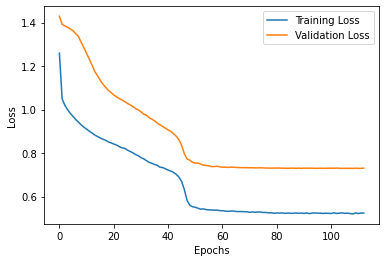

In [116]:
folder_name = 'models/attention/1,1,1/'


from matplotlib import pyplot as plt

for i in range(len(training_loss)):
  training_loss[i] = training_loss[i].cpu()

for i in range(len(validation_loss)):
  validation_loss[i] = validation_loss[i].cpu()


training_loss_ = np.array(training_loss)
validation_loss_ = np.array(validation_loss)


fig = plt.figure()
plt.plot(training_loss_)
plt.plot(validation_loss_)
plt.legend(["Training Loss", "Validation Loss"])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()
fig.savefig(folder_name + 'loss_vs_epoch.png')

In [119]:
total_batch = int(len(newsgroups_test.data)/batch_size)
correct = 0
total = 0
# Loop over all batches
for i in range(total_batch):
    batch_x,batch_y = get_batch(data['test'],i,batch_size)

    articles = Variable(torch.LongTensor(batch_x)).to(device)
    labels = Variable(torch.LongTensor(batch_y)).to(device)

    # Final validation accuracy
    total, correct = 0, 0
    mynet.eval()
    y_test_pred = mynet(articles)
    predicted = torch.argmax(y_test_pred, 1)

    total += y_test_pred.size(0)

    correct += (predicted == labels).sum()

print(f'Accuracy of the model is: {100*correct/total:.2f}%')

/content/drive/MyDrive/Github/ARDL/cnn.py:60: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return a, F.log_softmax(y)
/content/drive/MyDrive/Github/ARDL/dnn.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return a, F.log_softmax(y)
/content/drive/MyDrive/Github/ARDL/lstm.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return a, F.log_softmax(y)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the model is: 72.85%


In [121]:
lstm_models

[LSTM(
   (embedding): Embedding(151353, 50)
   (lstm): LSTM(50, 45, num_layers=6, batch_first=True, dropout=0.5)
   (fc): Linear(in_features=22500, out_features=7, bias=True)
   (att): Linear(in_features=22500, out_features=7, bias=True)
 )]

In [128]:
torch.load("models/lstm/model_2_09_03/model.pt")['accuracy']

72.66

In [129]:
path = "models/lstm"
files = os.listdir(path)

for file in files:
  print(file)

model_2_09_03
model_1_09_03
.ipynb_checkpoints
